In [1]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Descriptors
import gc
import rdkit
import numpy as np
import pandas as pd
from rdkit import Chem  # To extract information of the molecules
from mordred import Calculator, descriptors  # To calculate descriptors
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
from mordred import Calculator, descriptors  # To calculate descriptors
# from molml.features import CoulombMatrix  # To calculate the coulomb matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from catboost import CatBoostRegressor

# Загрузка обучающих данных

Перед началом обучения моделей создайте директорию training_datasets и поместите туда обучающие датасеты

### Преобразуем мг/кг в другой формат

In [ ]:
def upload_smiles(file_name, target_columns=None):
    """
    Функция для загрузки датасета
    :param file_name: str
    :param target_columns: LIST of str
    :return:
    """
    if target_columns:
        cols = ['smiles']  # Columns names
        for i, c in enumerate(target_columns):
            cols.append(c)
        df = pd.read_csv(file_name, names=cols, skiprows=1)
    else:
        df = pd.read_csv(file_name, skiprows=0)

    df.dropna(inplace=True, axis=0)
    return df


datasets_path = 'training_datasets'  # ДАТАСЕТЫ НУЖНО ПОМЕСТИТЬ СЮДА
os.makedirs(datasets_path, exist_ok=True)
lg_datasets_path = 'lg_datasets'
os.makedirs(lg_datasets_path, exist_ok=True)


for file_name in os.listdir(datasets_path):
    if file_name[-4:] != '.csv':
        continue
    dataset_file_path = datasets_path + '/' + file_name
    target_name = file_name.split('_')[-1][:-4]
    df = upload_smiles(dataset_file_path, target_columns=[target_name])

    # df = df.iloc[:1001, :]  # For fast checking

    #Getting molecules from SMILES
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
    # Add hidrogen molecules
    try:
        df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
    except: # Hydrogen exists
        pass

    # Convert to moles
    df['mw'] = df['mol'].apply(lambda x: Descriptors.MolWt(x))

    df[f'{target_name}_mole/kg'] = df[target_name] / 1000 / df['mw']

    # Logarithm
    df[f'{target_name}_lg(mole/kg)'] = - np.log10(df[f'{target_name}_mole/kg'])

    new_df = df.loc[:, ['smiles', f'{target_name}_lg(mole/kg)']]
    new_df_path = lg_datasets_path + '/lg_' + file_name

    # Save to file
    try:
        new_df.to_csv(new_df_path, index=False)
    except PermissionError:
        print(f"Error! File {file_name} exists and it's opened! Close it before overwriting.")
    del df

%reset -f  # Clear the memory

#### Сделаем дескрипторы, которые модель может интерпретировать

In [ ]:

descripted_datasets_path = "descriptors"
os.makedirs(descripted_datasets_path, exist_ok=True)

canonized = not bool(input(
    "Представлены ли ваши данные в форме Canonize SMILES?\n"
    "Введите любой символ для YES, пропустите для NO"))


for file_name in os.listdir(lg_datasets_path):
    if file_name[-4:] != '.csv':
        continue
    target_name = file_name.split('_')[-1][:-4]  # Getting the target type, clising the .csv
    dataset_file_path = lg_datasets_path + '/' + file_name
    df = upload_smiles(dataset_file_path, target_columns=[target_name])

    # df = df.iloc[:1001, :]  # For fast checking


    if not canonized:
        # Then we convert to Canonical SMILES
        df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

        # Checking if there are None values
        df['mol'].isnull().sum()

        try:
            # Add hidrogen molecules
            df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
        except:  # Already exists
            pass

        # Transform each element
        df['smiles'] = list(map(
            lambda mol: Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True),
            df['smiles'])
        )
    # Getting molecules from Canon SMILES
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

    if df['mol'].isnull().sum(): # Checking if there are None values
        df.dropna(inplace=True, axis=0)

    df_pieces = np.array_split(df, df.shape[0] // 1000 + 1)
    # Descripting

    # Use generator to care about memory
    df_desc = pd.concat([
        Calculator(descriptors, ignore_3D=True).pandas(df_piece['mol'])
        for df_piece in df_pieces
    ]
    )
    print(df_desc.shape)

    # Add smiles to final dataset
    df_desc[target_name] = df[target_name]

    dataset_file_name = (
            descripted_datasets_path + '/descripted_' + file_name
    )
    # Save to file
    df_desc.to_csv(dataset_file_name)
    del df_desc
    del df
    gc.collect()

%reset -f

# Проведём анализ одного из датасетов

In [2]:
datasets_path = 'descriptors'

In [3]:
os.listdir(datasets_path)

['descripted_lg_intraperitoneal_LDLo.csv',
 'descripted_lg_intravenous_LD50.csv',
 'descripted_lg_intravenous_LDLo.csv',
 'descripted_lg_oral_LD50.csv',
 'descripted_lg_oral_LDLo.csv',
 'descripted_lg_skin_LD50.csv',
 'descripted_lg_skin_LDLo.csv',
 'descripted_lg_subcutaneous_LD50.csv',
 'descripted_lg_subcutaneous_LDLo.csv']

1) Показатель LD50 Skin

In [4]:
df = pd.read_csv(datasets_path + '/' +'descripted_lg_skin_LD50.csv', names=None, skiprows=0)
# df.dropna(inplace=True, axis=0)
df.head(2)

C:\Users\possessor\AppData\Local\Temp\ipykernel_15804\722534372.py:1: DtypeWarning: Columns (466,467,562,563,828,844,1301) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datasets_path + '/' +'descripted_lg_skin_LD50.csv', names=None, skiprows=0)


,Unnamed: 0,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,LD50
0,0,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,...,31.665095,85.052764,6.542520,28,3,24.0,22.0,4.3125,1.375,2.753900
1,1,4.242641,4.000000,0,0,8.000000,2.000000,4.000000,8.000000,1.333333,...,30.941317,79.042199,7.185654,27,3,24.0,24.0,1.5000,1.500,1.898198


In [5]:
df.shape

(1001, 1615)

Нам подойдут только числовые данные:

In [6]:
df.select_dtypes(include=[np.number]).shape

(1001, 1100)

Одну треть данных придётся убрать

In [7]:
df = df.select_dtypes(include=[np.number])
df.shape

(1001, 1100)

In [9]:
y = df['LD50']

In [10]:
X = df.drop(['LD50'], axis=1)

In [11]:
# Delete index-column "Unnamed" if exists
X.drop(X.columns[0], axis=1, inplace=True)
X.head(2)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,2.626363,...,7.989899,31.665095,85.052764,6.542520,28,3,24.0,22.0,4.3125,1.375
1,4.242641,4.000000,0,0,8.000000,2.000000,4.000000,8.000000,1.333333,2.687624,...,7.627057,30.941317,79.042199,7.185654,27,3,24.0,24.0,1.5000,1.500


In [12]:
# Checking if there are None values
X.isnull().sum().sum()

0

In [13]:
X.describe()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,9.387829,8.665592,0.054945,0.094905,15.634240,2.199986,4.369666,15.634240,1.183018,3.323855,...,8.674044,44.208130,201.236917,8.356331,422.742258,15.760240,59.314685,65.498501,5.567183,3.065587
std,4.833930,3.884279,0.289790,0.419504,7.803980,0.243174,0.457146,7.803980,0.095911,0.520453,...,1.214665,12.663434,94.680487,4.043696,699.343061,11.915304,34.165097,42.578542,2.360021,1.319154
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,0.800000,1.407606,...,1.098612,7.493061,31.042199,4.358613,1.000000,0.000000,2.000000,1.000000,0.750000,0.750000
25%,5.875634,6.068455,0.000000,0.000000,10.175084,2.052881,4.105762,10.175084,1.136687,3.008457,...,8.052933,36.546958,134.094294,6.004179,86.000000,7.000000,36.000000,36.000000,3.861111,2.166667
50%,8.633455,8.248586,0.000000,0.000000,14.510052,2.236068,4.472136,14.510052,1.194315,3.372523,...,8.906935,42.724397,183.847482,7.177347,215.000000,14.000000,54.000000,59.000000,5.173611,2.888889
75%,12.130205,10.923744,0.000000,0.000000,20.064146,2.352239,4.675495,20.064146,1.245407,3.691183,...,9.477386,50.342321,258.960312,9.094782,495.000000,22.000000,78.000000,89.000000,6.944444,3.736111
max,42.893681,33.219814,4.000000,4.000000,69.059166,3.187649,6.093353,69.059166,1.475343,4.955612,...,12.045147,115.108035,703.239061,34.370465,10968.000000,109.000000,320.000000,417.000000,21.340278,10.847222


### Удаление выбросов

Посмотрим на несколько гистограмм

<Axes: >

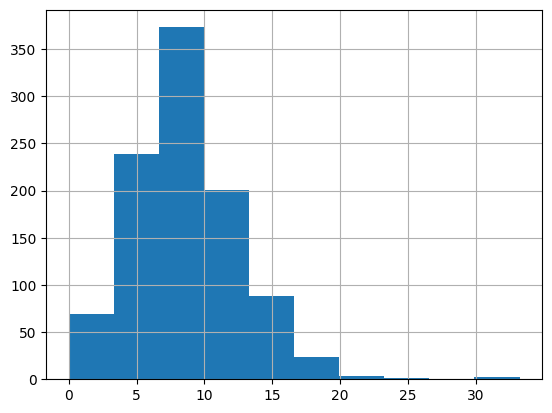

In [14]:
X.iloc[:, 1].hist()

<Axes: >

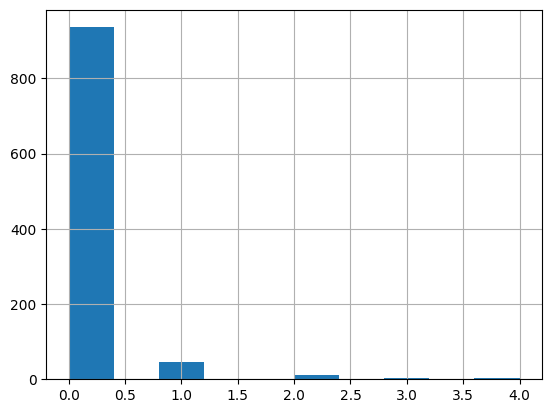

In [15]:
X.iloc[:, 3].hist()

<Axes: >

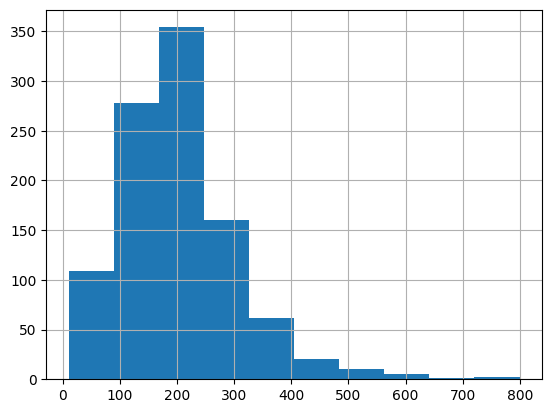

In [16]:
X.iloc[:, 90].hist()

<Axes: >

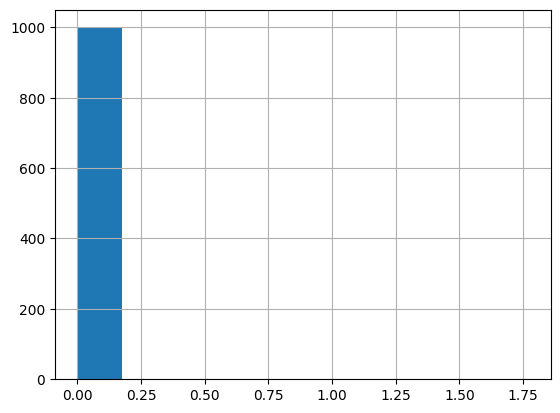

In [17]:
X.iloc[:, 700].hist()

<Axes: >

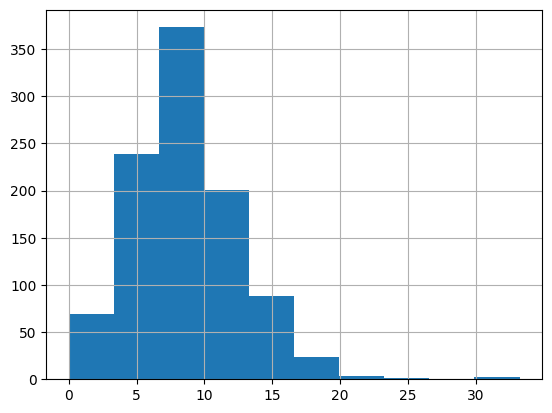

In [18]:
X.iloc[:, 1].hist()

Гистограммы подтверждают данные функции describe() - в данных много выбросов

In [19]:
description = X.describe()

In [20]:
description

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,9.387829,8.665592,0.054945,0.094905,15.634240,2.199986,4.369666,15.634240,1.183018,3.323855,...,8.674044,44.208130,201.236917,8.356331,422.742258,15.760240,59.314685,65.498501,5.567183,3.065587
std,4.833930,3.884279,0.289790,0.419504,7.803980,0.243174,0.457146,7.803980,0.095911,0.520453,...,1.214665,12.663434,94.680487,4.043696,699.343061,11.915304,34.165097,42.578542,2.360021,1.319154
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,0.800000,1.407606,...,1.098612,7.493061,31.042199,4.358613,1.000000,0.000000,2.000000,1.000000,0.750000,0.750000
25%,5.875634,6.068455,0.000000,0.000000,10.175084,2.052881,4.105762,10.175084,1.136687,3.008457,...,8.052933,36.546958,134.094294,6.004179,86.000000,7.000000,36.000000,36.000000,3.861111,2.166667
50%,8.633455,8.248586,0.000000,0.000000,14.510052,2.236068,4.472136,14.510052,1.194315,3.372523,...,8.906935,42.724397,183.847482,7.177347,215.000000,14.000000,54.000000,59.000000,5.173611,2.888889
75%,12.130205,10.923744,0.000000,0.000000,20.064146,2.352239,4.675495,20.064146,1.245407,3.691183,...,9.477386,50.342321,258.960312,9.094782,495.000000,22.000000,78.000000,89.000000,6.944444,3.736111
max,42.893681,33.219814,4.000000,4.000000,69.059166,3.187649,6.093353,69.059166,1.475343,4.955612,...,12.045147,115.108035,703.239061,34.370465,10968.000000,109.000000,320.000000,417.000000,21.340278,10.847222


Удалим выбросы: если третий квартиль равен нулю, удаляем весь столбец. Иначе удаляем только выбросы.

In [22]:
for column in X.columns:
    d = description[column]
    qrtl2 = d['50%']
    qrtl3 = d['75%']
    max_v = d['max']
    if qrtl2 == 0.0 and qrtl3 == 0.0:
        X.drop(column, axis=1, inplace=True)
    else:
        X = X[X[column] < max_v * 0.99]
    del d
    del qrtl2
    del qrtl3
    del max_v

In [23]:
X.shape

(318, 769)

Splitting the data

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

# Model training

In [18]:
def calculate_rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

In [79]:
def show_result(y_test, y_pred):
    return pd.DataFrame(
        np.array(
            [np.array(y_test), y_pred, np.array(y_test) - y_pred]
        ).T,
        columns=['TRUE', 'PRED', 'ABS ERROR'])

## ML models

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Linear Regression

In [89]:
model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [90]:
y_pred = model.predict(X_test)

In [92]:
calculate_rmse(y_test=y_test, y_pred=y_pred)

0.1612917251124116

In [93]:
show_result(y_test=y_test, y_pred=y_pred)

,TRUE,PRED,ABS ERROR
0,0.002040,0.012115,-0.010075
1,0.012257,0.019367,-0.007110
2,0.009754,0.020809,-0.011055
3,0.031223,0.031029,0.000195
4,0.005073,0.011688,-0.006615
...,...,...,...
1670,0.026842,0.023602,0.003240
1671,0.026300,0.005669,0.020632
1672,0.000777,0.000721,0.000056
1673,0.004313,0.011395,-0.007081


### Random Forest Regression

где-нибудь здесь можно добавить catboost...

In [85]:
model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', verbose=1, random_state=42, n_jobs=10)
model.fit(X_train, y_train)

# Get predicted data
y_pred = model.predict(X_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    5.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished


In [87]:
calculate_rmse(y_test=y_test, y_pred=y_pred)

0.013924442720712915

In [88]:
show_result(y_test=y_test, y_pred=y_pred)

,TRUE,PRED,ABS ERROR
0,0.002040,0.020003,-0.017963
1,0.012257,0.022345,-0.010088
2,0.009754,0.027241,-0.017487
3,0.031223,0.038025,-0.006802
4,0.005073,0.004022,0.001052
...,...,...,...
1670,0.026842,0.015526,0.011316
1671,0.026300,0.009606,0.016694
1672,0.000777,0.005574,-0.004798
1673,0.004313,0.011972,-0.007659


### CatBoost

In [ ]:
model = CatBoostRegressor(iterations=20000,
                          learning_rate=1,
                          depth=2)
# Fit model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
calculate_rmse(y_test=y_test, y_pred=y_pred)

In [ ]:
show_result(y_test=y_test, y_pred=y_pred)

CatBoost даёт нам самое лучше качество, будем использовать его.

### Классификационная модель SVC

In [ ]:
# создаем и обучаем pipeline со стандартизацией и SVC классификатором
pipe = Pipeline([
    ('scaler', StandardScaler()), # стандартизация признаков
    ('knn', SVC(C = 2, probability = True)) # SVC классификатор
])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_score(y_test, y_pred)

#### Обучение моделей для каждого показателя

In [29]:
descripted_datasets_path = "descriptors"

In [36]:
def build_cat_model(file_name):
    data = pd.read_csv(descripted_datasets_path + '/' + file_name, skiprows=0)


    data = data.select_dtypes(include=[np.number])

    local_y = data['LD50']
    local_X = data.drop(['LD50'], axis=1)

    # Delete index-column "Unnamed" if exists
    local_X.drop(X.columns[0], axis=1, inplace=True)
    local_X.dropna(axis=0)


    description = local_X.describe()
    for column in local_X.columns:
        d = description[column]
        qrtl2 = d['50%']
        qrtl3 = d['75%']
        max_v = d['max']
        if qrtl2 == 0.0 and qrtl3 == 0.0:
            X.drop(column, axis=1, inplace=True)
        else:
            X = local_X[local_X[column] < max_v * 0.99]
        del d
        del qrtl2
        del qrtl3
        del max_v

    model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', verbose=1, random_state=42, n_jobs=10)
    model.fit(local_X, local_y)

    return model

In [35]:
models = {}

In [34]:
for file_name in os.listdir(descripted_datasets_path):
    model_name = '-'.join(file_name.split('_')[-2:])[:-4]
    models[model_name] = build_cat_model(file_name)

intraperitoneal-LDLo
intravenous-LD50
intravenous-LDLo
oral-LD50
oral-LDLo
skin-LD50
skin-LDLo
subcutaneous-LD50
subcutaneous-LDLo


## Making the predictions

In [ ]:
input_df = pd.read_csv('input.csv', skiprows=0)

#### Make a descriptor

In [ ]:
for file_name in os.listdir(lg_datasets_path):
    if file_name[-4:] != '.csv':
        continue
    target_name = file_name.split('_')[-1][:-4]  # Getting the target type, clising the .csv
    dataset_file_path = lg_datasets_path + '/' + file_name
    df = upload_smiles(dataset_file_path, target_columns=[target_name])

    # df = df.iloc[:1001, :]  # For fast checking

    # Getting molecules from Canon SMILES
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

    if df['mol'].isnull().sum():  # Checking if there are None values
        df.dropna(inplace=True, axis=0)

    df_pieces = np.array_split(df, df.shape[0] // 1000 + 1)
    # Descripting

    # Use generator to care about memory
    df_desc = pd.concat([
        Calculator(descriptors, ignore_3D=True).pandas(df_piece['mol'])
        for df_piece in df_pieces
    ]
    )

    # Save to file
    df_desc.to_csv('desc_input.csv')
    del df_desc
    del df
    gc.collect()

%reset -f

### Load X and Y

In [ ]:
smiles = pd.read_csv('input.csv', skiprows=0)

In [ ]:
X_test = pd.read_csv('desc_input.csv', skiprows=0)

In [ ]:
# Prediction and output

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    pd.DataFrame(
        np.array(
            [smiles, y_pred]
        ).T,
        columns=['smiles', name]
    ).to_csv(f'{name}_output.csv')